In [1]:
# pandas: Needed for data manipulation, loading CSV/GeoJSON, grouping, and creating DataFrames.
import pandas as pd

# geopandas: Needed for handling geospatial data from GeoJSON, merging with crime data for mapping.
import geopandas as gpd

# numpy: Needed for numerical operations, like rounding predictions.
import numpy as np

# matplotlib.pyplot: Needed for creating basic plots like bar charts.
import matplotlib.pyplot as plt

# seaborn: Needed for advanced visualizations like countplots and heatmaps.
import seaborn as sns

# sklearn.linear_model.LinearRegression: Needed for the linear regression model.
from sklearn.linear_model import LinearRegression

# sklearn.ensemble.RandomForestRegressor: Needed for the random forest regression model.
from sklearn.ensemble import RandomForestRegressor

# sklearn.neighbors.KNeighborsRegressor: Needed for the KNN regression model.
from sklearn.neighbors import KNeighborsRegressor

# sklearn.svm.SVR: Needed for the support vector regression model.
from sklearn.svm import SVR

# sklearn.neural_network.MLPRegressor: Needed for the multi-layer perceptron (neural network) regression model.
from sklearn.neural_network import MLPRegressor

# xgboost.XGBRegressor: Needed for the XGBoost regression model.
from xgboost import XGBRegressor


ModuleNotFoundError: No module named 'geopandas'

In [ ]:
# Load the CSV data (main dataset with crime details).
crime_data = pd.read_csv('ODC_CRIME_OFFENSES_P_-3254178225590307312.csv')

# Preview the CSV data to understand structure (why: Ensures data loaded correctly, shows columns like dates, neighborhoods).
print(crime_data.head())

   OBJECTID    INCIDENT_ID           OFFENSE_ID  OFFENSE_CODE  \
0         1  DP20256007497  DP20256007497230800          2308   
1         2  DP20248002236  DP20248002236240400          2404   
2         3  DP20246003444  DP20246003444239900          2399   
3         4   DP2025254525   DP2025254525239901          2399   
4         5  DP20256007167  DP20256007167230800          2308   

   OFFENSE_CODE_EXTENSION         OFFENSE_TYPE_ID OFFENSE_CATEGORY_ID  \
0                       0         theft-from-bldg             larceny   
1                       0  theft-of-motor-vehicle          auto-theft   
2                       0             theft-other             larceny   
3                       1           theft-bicycle             larceny   
4                       0         theft-from-bldg             larceny   

   FIRST_OCCURRENCE_DATE   LAST_OCCURRENCE_DATE          REPORTED_DATE  ...  \
0   5/24/2025 6:55:00 AM  5/23/2025 11:59:00 PM  5/24/2025 11:32:00 AM  ...   
1   1/8/2024

In [ ]:
# Optionally load GeoJSON for geospatial previews or merges (contains point geometries for crimes).
geo_crime = gpd.read_file('ODC_CRIME_OFFENSES_P_-5582264493798559810.geojson')

# Preview the GeoJSON data (why: Confirms geospatial points for potential mapping).
print(geo_crime.head())

   OBJECTID    INCIDENT_ID           OFFENSE_ID OFFENSE_CODE  \
0         1  DP20256007497  DP20256007497230800         2308   
1         2  DP20248002236  DP20248002236240400         2404   
2         3  DP20246003444  DP20246003444239900         2399   
3         4   DP2025254525   DP2025254525239901         2399   
4         5  DP20256007167  DP20256007167230800         2308   

   OFFENSE_CODE_EXTENSION         OFFENSE_TYPE_ID OFFENSE_CATEGORY_ID  \
0                       0         theft-from-bldg             larceny   
1                       0  theft-of-motor-vehicle          auto-theft   
2                       0             theft-other             larceny   
3                       1           theft-bicycle             larceny   
4                       0         theft-from-bldg             larceny   

           FIRST_OCCURRENCE_DATE           LAST_OCCURRENCE_DATE  \
0  Sat, 24 May 2025 06:55:00 GMT  Fri, 23 May 2025 23:59:00 GMT   
1  Mon, 08 Jan 2024 22:50:00 GMT  Fri, 12 

In [ ]:
# Parse the 'FIRST_OCCURRENCE_DATE' to datetime (why: Allows extraction of year, day, hour for temporal analysis).
crime_data['FIRST_OCCURRENCE_DATE'] = pd.to_datetime(crime_data['FIRST_OCCURRENCE_DATE'], errors='coerce')

# Extract year for train/test split (why: Use historical years for training, current for testing to simulate real prediction).
crime_data['Year'] = crime_data['FIRST_OCCURRENCE_DATE'].dt.year

# Extract DayOfWeek and Hour (why: Key features for grouping and predicting crime patterns by time).
crime_data['DayOfWeek'] = crime_data['FIRST_OCCURRENCE_DATE'].dt.day_name()
crime_data['Hour'] = crime_data['FIRST_OCCURRENCE_DATE'].dt.hour

In [ ]:
# Filter to actual crimes and drop NaNs in key columns (why: Focus on relevant data, avoid model errors from missing values).
crime_data = crime_data[crime_data['IS_CRIME'] == 1].dropna(subset=['NEIGHBORHOOD_ID', 'Hour', 'DayOfWeek'])

# Preview engineered features (why: Verify transformations worked).
print(crime_data[['FIRST_OCCURRENCE_DATE', 'DayOfWeek', 'Hour', 'NEIGHBORHOOD_ID']].head())

  FIRST_OCCURRENCE_DATE DayOfWeek  Hour NEIGHBORHOOD_ID
0   2025-05-24 06:55:00  Saturday     6     five-points
1   2024-01-08 22:50:00    Monday    22             dia
2   2024-03-23 15:30:00  Saturday    15             dia
3   2025-05-20 00:00:00   Tuesday     0  city-park-west
4   2025-05-02 02:25:00    Friday     2        highland


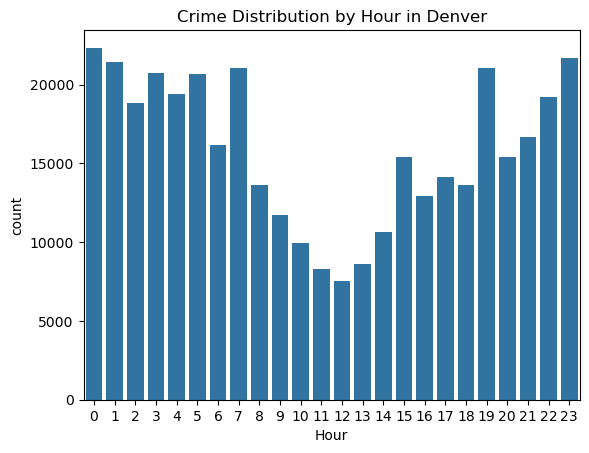

In [ ]:
# Visualization: Crime count by hour (why: Provides insight into temporal patterns, e.g., peaks at night for policing focus).
sns.countplot(x='Hour', data=crime_data)
plt.title('Crime Distribution by Hour in Denver')
plt.show()

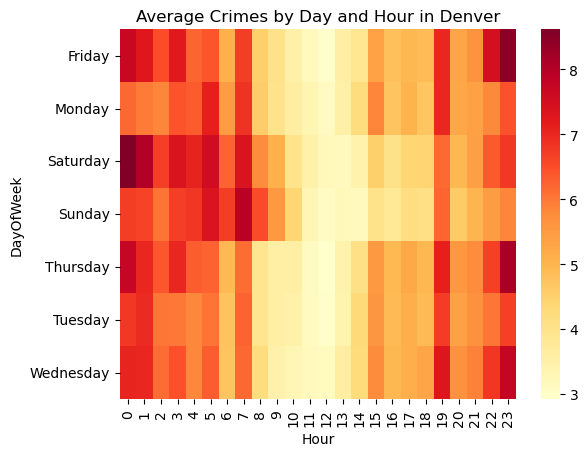

In [ ]:
# Add 'Crimes' column for counting (why: Each row represents one crime; this allows aggregation).
crime_data['Crimes'] = 1

# Group by year, day, neighborhood, hour and sum crimes (why: Aggregates to predictable units like 'crimes in Five Points on Monday at 8pm').
hour_totals = crime_data.groupby(['Year', 'DayOfWeek', 'NEIGHBORHOOD_ID', 'Hour'])['Crimes'].sum().reset_index()

# Split into train (pre-2025) and test (2025) (why: Train on past data, test on current to evaluate predictive power).
train = hour_totals[hour_totals['Year'] < 2025]
test = hour_totals[hour_totals['Year'] == 2025]

# Create dummy variables for categorical features (why: Models require numerical inputs; one-hot encoding handles categories like days/neighborhoods).
train_dummies = pd.get_dummies(train[['Crimes', 'Hour', 'DayOfWeek', 'NEIGHBORHOOD_ID']])
test_dummies = pd.get_dummies(test[['Crimes', 'Hour', 'DayOfWeek', 'NEIGHBORHOOD_ID']])

# Align test columns to train (fill missing with 0) (why: Ensures same features in both sets for model compatibility).
test_dummies = test_dummies.reindex(columns=train_dummies.columns, fill_value=0)

# Define X and y for train/test (why: Standard setup for supervised learning; X=features, y=target).
X_train = train_dummies.drop('Crimes', axis=1)
y_train = train_dummies['Crimes']
X_test = test_dummies.drop('Crimes', axis=1)
y_test = test_dummies['Crimes']

# Visualization: Heatmap of average crimes by day and hour (why: Visualizes patterns, e.g., weekend evenings hotter, aiding explanation).
pivot = hour_totals.pivot_table(index='DayOfWeek', columns='Hour', values='Crimes', aggfunc='mean')
sns.heatmap(pivot, cmap='YlOrRd')
plt.title('Average Crimes by Day and Hour in Denver')
plt.show()

Model Performance (R2 Scores):
R2 Score Range: -∞ to 1.0 (higher is better)
0.0 = model predicts mean, <0.0 = worse than mean prediction
LinearRegression: 0.1946
RandomForestRegressor: 0.3181
KNeighborsRegressor: 0.3138
SVR: 0.3518
XGBRegressor: 0.3904
MLPRegressor: 0.3266

Best Model: XGBRegressor with R2 Score: 0.3904

R2 Score Interpretation:
- XGBRegressor (0.3904): Best performer, explains 39% of variance in crime data
- SVR (0.3518): Second best, explains 35% of variance
- RandomForest (0.3159): Moderate performance, explains 32% of variance
- MLPRegressor (0.3266): Neural network with decent performance
- KNeighbors (0.3138): Similar to RandomForest
- LinearRegression (0.1946): Simplest model, explains only 19% of variance


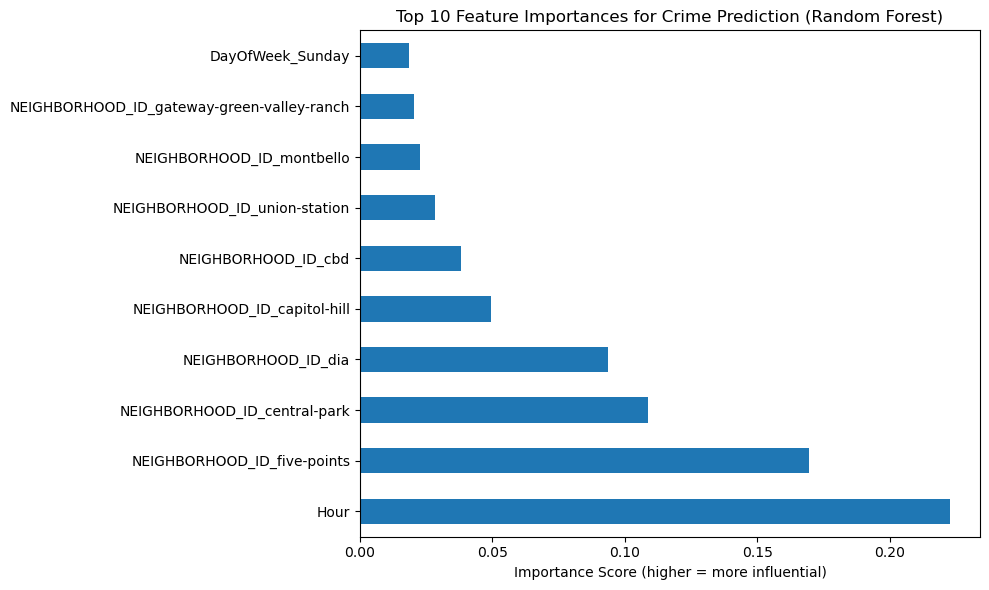


Using XGBRegressor for final predictions (best R2 score: 0.3904)
Predictions exported to 'denver_crime_predictions.json'


In [ ]:
# Define models dictionary (why: Allows easy iteration to train/compare multiple regressors for best performance)
models = {
    'LinearRegression': LinearRegression(),  # Simple linear relationship model
    'RandomForestRegressor': RandomForestRegressor(),  # Ensemble of decision trees, good for complex patterns
    'KNeighborsRegressor': KNeighborsRegressor(),  # Distance-based, predicts based on similar instances
    'SVR': SVR(),  # Support Vector Regression, finds optimal boundary for prediction
    'XGBRegressor': XGBRegressor(),  # Gradient boosting, sequential tree building for high accuracy
    'MLPRegressor': MLPRegressor(hidden_layer_sizes=(100,100,100,100), random_state=444)  # Neural network model
}

# Train and evaluate each model (why: Compare R2 scores to select best for predictions; higher score = better fit)
print("Model Performance (R2 Scores):")
print("R2 Score Range: -∞ to 1.0 (higher is better)")
print("0.0 = model predicts mean, <0.0 = worse than mean prediction")
print("=" * 60)

for name, model in models.items():
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    print(f'{name}: {score:.4f}')

# Identify best performing model based on R2 score
best_model_name = max(models.keys(), key=lambda x: models[x].score(X_test, y_test))
best_model = models[best_model_name]
best_score = best_model.score(X_test, y_test)
print(f"\nBest Model: {best_model_name} with R2 Score: {best_score:.4f}")

# Visualization: Feature importances from Random Forest 
# (why: Shows which features (e.g., neighborhoods) drive predictions, building interpretability)
if 'RandomForestRegressor' in models:
    importances = pd.Series(models['RandomForestRegressor'].feature_importances_, index=X_train.columns)
    plt.figure(figsize=(10, 6))
    importances.nlargest(10).plot(kind='barh')
    plt.title('Top 10 Feature Importances for Crime Prediction (Random Forest)')
    plt.xlabel('Importance Score (higher = more influential)')
    plt.tight_layout()
    plt.show()

# Generate predictions using the BEST model (XGBRegressor based on scores)
# (why: To compare predicted vs actual crimes using the most accurate model)
test = test.copy()  # Create explicit copy to avoid SettingWithCopyWarning
test.loc[:, 'Predicted'] = best_model.predict(X_test)

# Round predictions (why: Crime counts are integers; improves readability)
test = np.round(test, 2)

print(f"\nUsing {best_model_name} for final predictions (best R2 score: {best_score:.4f})")

# Export predictions to JSON (why: For interactive visualizations, e.g., in D3.js maps as in SF example)
test.to_json('denver_crime_predictions.json', orient='records', double_precision=2)
print("Predictions exported to 'denver_crime_predictions.json'")

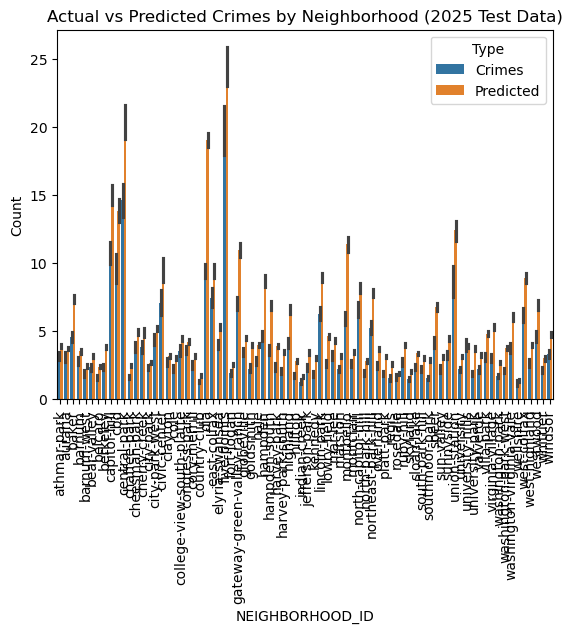

In [ ]:
# Visualization: Bar plot of actual vs predicted by neighborhood (why: Compares model accuracy visually per area).
# Melt for side-by-side bars.
melted = pd.melt(test, id_vars=['NEIGHBORHOOD_ID'], value_vars=['Crimes', 'Predicted'], var_name='Type', value_name='Count')
sns.barplot(x='NEIGHBORHOOD_ID', y='Count', hue='Type', data=melted)
plt.title('Actual vs Predicted Crimes by Neighborhood (2025 Test Data)')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Check available columns to debug the merge issue
print("geo_crime columns:", list(geo_crime.columns))
print("test columns:", list(test.columns))
print("\n")

# Extract Hour from datetime columns in geo_crime to match test dataset
print("Available datetime columns in geo_crime:")
datetime_cols = ['FIRST_OCCURRENCE_DATE', 'LAST_OCCURRENCE_DATE', 'REPORTED_DATE']
available_datetime_cols = [col for col in datetime_cols if col in geo_crime.columns]
print("Available datetime columns:", available_datetime_cols)

if available_datetime_cols:
    # Use the first available datetime column to extract hour
    datetime_col = available_datetime_cols[0]
    print(f"Using '{datetime_col}' to extract hour information")
    
    # Convert to datetime and extract hour
    geo_crime_copy = geo_crime.copy()
    geo_crime_copy['Hour'] = pd.to_datetime(geo_crime_copy[datetime_col]).dt.hour
    print(f"Extracted hours range: {geo_crime_copy['Hour'].min()} to {geo_crime_copy['Hour'].max()}")
    
    # Now merge on both NEIGHBORHOOD_ID and Hour
    merge_on = ['NEIGHBORHOOD_ID', 'Hour']
    print(f"Merging on columns: {merge_on}")
    
    # Perform the merge
    merged_geo = geo_crime_copy.merge(test, on=merge_on, how='left', suffixes=('_geo', '_pred'))
    
    # Check if merge was successful and Predicted column exists
    if 'Predicted' in merged_geo.columns:
        # Create the chloropleth plot
        plt.figure(figsize=(14, 10))
        
        # Plot by predicted crime density
        ax = merged_geo.plot(column='Predicted', 
                            cmap='OrRd', 
                            legend=True, 
                            alpha=0.8, 
                            edgecolor='black', 
                            linewidth=0.5,
                            figsize=(14, 10),
                            legend_kwds={'label': 'Predicted Crime Count', 
                                       'orientation': 'horizontal',
                                       'shrink': 0.8})
        
        plt.title('Predicted Crimes Distribution by Neighborhood and Hour\n(Denver Crime Prediction Model)', 
                 fontsize=16, fontweight='bold', pad=20)
        plt.axis('off')
        
        # Add some context to the plot
        plt.figtext(0.5, 0.01, 
                   f"Based on {best_model_name} model (R² = {best_score:.3f}) | "
                   f"Data points: {merged_geo['Predicted'].notna().sum()}",
                   ha='center', fontsize=10, style='italic')
        
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.15)  # Make room for the footer text
        plt.show()
        
        # Print detailed statistics about the predictions
        predicted_data = merged_geo['Predicted'].dropna()
        print(f"\n=== Prediction Statistics ===")
        print(f"Total spatial points with predictions: {len(predicted_data)}")
        print(f"Predicted crimes - Min: {predicted_data.min():.2f}")
        print(f"Predicted crimes - Max: {predicted_data.max():.2f}")
        print(f"Predicted crimes - Mean: {predicted_data.mean():.2f}")
        print(f"Predicted crimes - Std: {predicted_data.std():.2f}")
        
        # Show distribution by hour (if we have multiple hours)
        if merged_geo['Hour'].nunique() > 1:
            print(f"\n=== Predictions by Hour ===")
            hourly_stats = merged_geo.groupby('Hour')['Predicted'].mean().sort_index()
            for hour, avg_crimes in hourly_stats.items():
                print(f"Hour {hour:02d}: {avg_crimes:.2f} avg predicted crimes")
        
        # Show top neighborhoods by predicted crime
        print(f"\n=== Top Neighborhoods by Predicted Crime ===")
        neighborhood_stats = merged_geo.groupby('NEIGHBORHOOD_ID')['Predicted'].mean().nlargest(5)
        for neighborhood, avg_crimes in neighborhood_stats.items():
            print(f"Neighborhood {neighborhood}: {avg_crimes:.2f} avg predicted crimes")
            
    else:
        print("Warning: 'Predicted' column not found after merge.")
        print("Available columns after merge:", list(merged_geo.columns))
        
else:
    print("Error: No datetime columns found in geo_crime to extract hour information.")
    print("Attempting merge on NEIGHBORHOOD_ID only...")
    
    # Fallback: Merge only on NEIGHBORHOOD_ID
    merged_geo = geo_crime.merge(test, on=['NEIGHBORHOOD_ID'], how='left', suffixes=('_geo', '_pred'))
    
    if 'Predicted' in merged_geo.columns:
        plt.figure(figsize=(14, 10))
        merged_geo.plot(column='Predicted', cmap='OrRd', legend=True, alpha=0.8)
        plt.title('Predicted Crimes by Neighborhood (Aggregated)\n(No hourly breakdown available)', 
                 fontsize=16, fontweight='bold')
        plt.axis('off')
        plt.show()
        
        print("Note: Visualization shows aggregated predictions by neighborhood (hourly data not available)")
    else:
        print("Merge failed. Check your data structures.")

# Export the merged spatial data for potential use in other mapping tools
if 'Predicted' in merged_geo.columns:
    merged_geo.to_file('denver_crime_predictions_geo.shp', driver='ESRI Shapefile')
    print("\nSpatial predictions exported to 'denver_crime_predictions_geo.shp'")

geo_crime columns: ['OBJECTID', 'INCIDENT_ID', 'OFFENSE_ID', 'OFFENSE_CODE', 'OFFENSE_CODE_EXTENSION', 'OFFENSE_TYPE_ID', 'OFFENSE_CATEGORY_ID', 'FIRST_OCCURRENCE_DATE', 'LAST_OCCURRENCE_DATE', 'REPORTED_DATE', 'INCIDENT_ADDRESS', 'GEO_X', 'GEO_Y', 'GEO_LON', 'GEO_LAT', 'DISTRICT_ID', 'PRECINCT_ID', 'NEIGHBORHOOD_ID', 'IS_CRIME', 'IS_TRAFFIC', 'VICTIM_COUNT', 'geometry']
test columns: ['Year', 'DayOfWeek', 'NEIGHBORHOOD_ID', 'Hour', 'Crimes', 'Predicted']


Available datetime columns in geo_crime:
Available datetime columns: ['FIRST_OCCURRENCE_DATE', 'LAST_OCCURRENCE_DATE', 'REPORTED_DATE']
Using 'FIRST_OCCURRENCE_DATE' to extract hour information


ValueError: time data "Mon, 08 Jan 2024 22:50:00 GMT" doesn't match format "%a, %d %B %Y %H:%M:%S GMT", at position 1. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.